# Proyecto 1:
### El objetivo principal es vincular de forma automática las opiniones de la ciudadanía con los Objetivos de Desarrollo Sostenible (ODS) 1, 3 y 4
- ODS 1: Fin de la pobreza
- ODS 3: Salud Y Bienestar
- ODS 4: Educación y calidad

# Importación e Instalación de librerías

In [6]:
!pip install nltk

In [7]:
!pip install imblearn

In [8]:
!pip install scikit-optimize


In [9]:
# Manejo de Datos y Matemáticas
import numpy as np
import pandas as pd

# Visualización de Datos
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Análisis Profundo de Datos (Perfilado)
from ydata_profiling import ProfileReport

# NLTK
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Scikit-learn y Skopt
import sklearn # Mantener importación general de sklearn si se usa en otras partes
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from skopt import BayesSearchCV
from skopt.space import Integer, Real

# from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [10]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /home/almanza33/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/almanza33/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/almanza33/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/almanza33/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/almanza33/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_da

True

# 0. Importación de los datos y Perfilamiento

In [11]:
df = pd.read_excel('Datos_proyecto.xlsx')
df.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


Primera preocupación: No es un set de datos muy grande. Tenemos tan solo 2424 filas.

In [13]:
profile = ProfileReport(df, title="Reporte")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 10.66it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

De acuerdo a un perfilamiento inicial, todos nuestros textos son únicos, no tenemos textos duplicados. Por otro lado, no tenemos fields con nulos.

Tenemos un problema y es que hay una diferencia sustancial entre la cantidad de datos para las diferentes categorías. Para la ODS 4, tenemos más del doble de datos que los que poseemos para la ODS 1. El undersampling no es una opción porque de por sí ya contamos con pocos datos para todas las categorías. Por esta razón, intentaremos con Oversampling. Es decir, aumentaremos la frecuencia de muestreo de las categorías con menos datos.

# 2. Visualización y exploración de los datos
Al ser un set de datos con pocas columnas (tan solo 2, siendo una de ellas el label) todo nuestro procesamiento se concentrará en la columna de textos. Nuestro enfoque se concentrará entonces en hacer de la columna textos lo más informativa posible. Esto mediante la eliminación de ruído (StopWords y Stemming).

## 2.1 Visualización preliminar
A continuación, realizaremos una visualización de nuestro conjunto de datos mediante una nube de palabras. El tamaño de cada palabra será representativa del número de veces que aparece en el set de datos.

In [14]:
def show_wordcloud(words, stopwords=[]):
    comment_words = ""

    for val in words:
        val = str(val)
        tokens = val.split()

        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens) + " "

    wordcloud = WordCloud(
        width=800,
        height=800,
        background_color="white",
        stopwords=stopwords,
        min_font_size=10,
    ).generate(comment_words)

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()

---------- Nube de palabras para label = 1 ----------


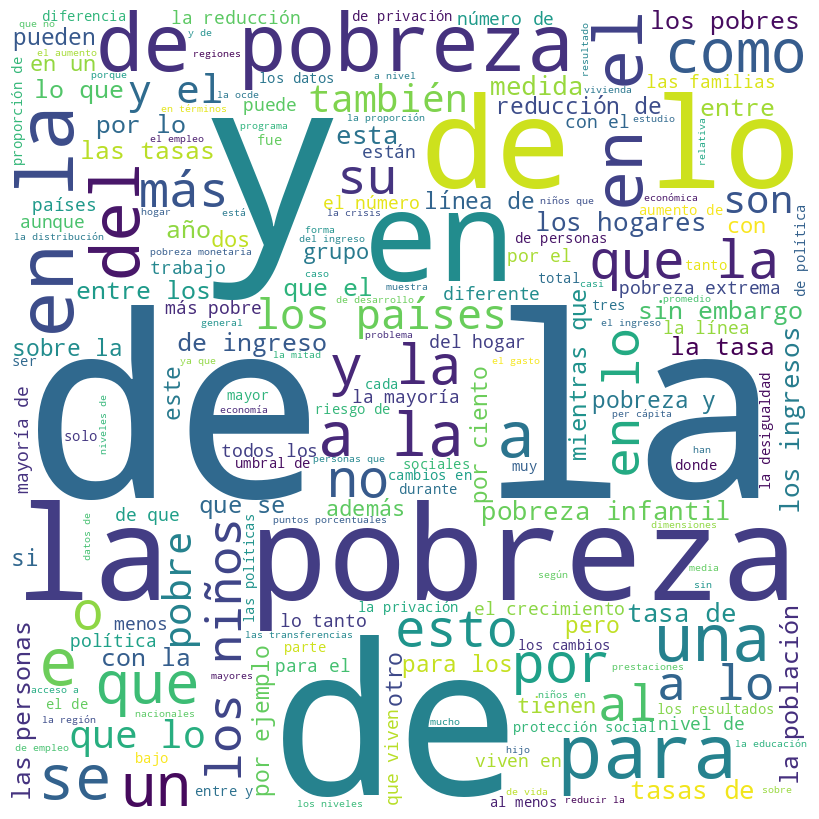

---------- Nube de palabras para label = 3 ----------


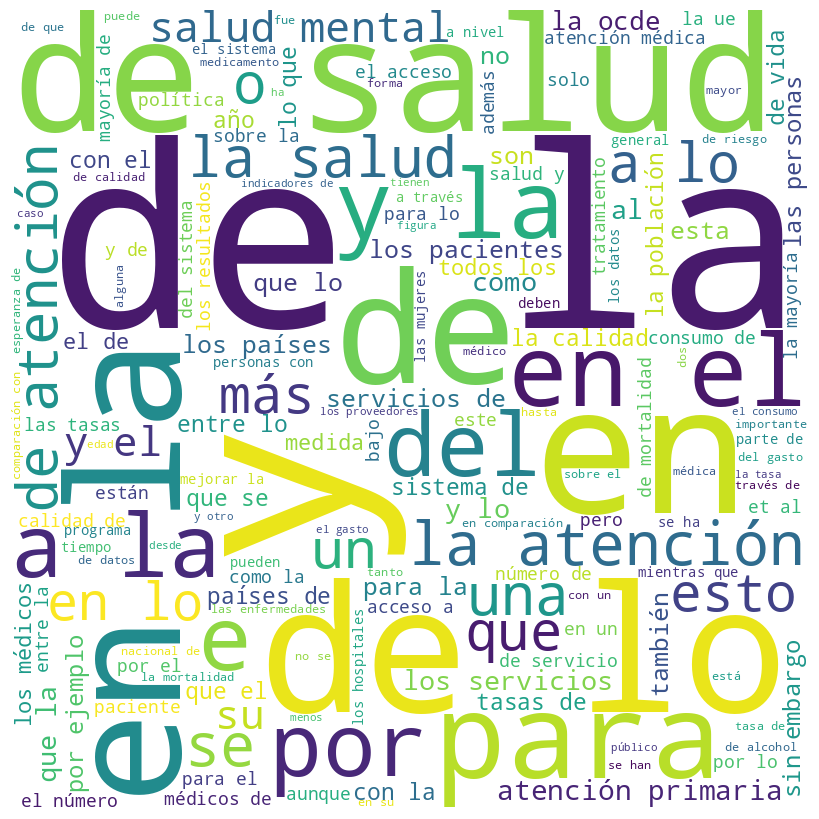

---------- Nube de palabras para label = 4 ----------


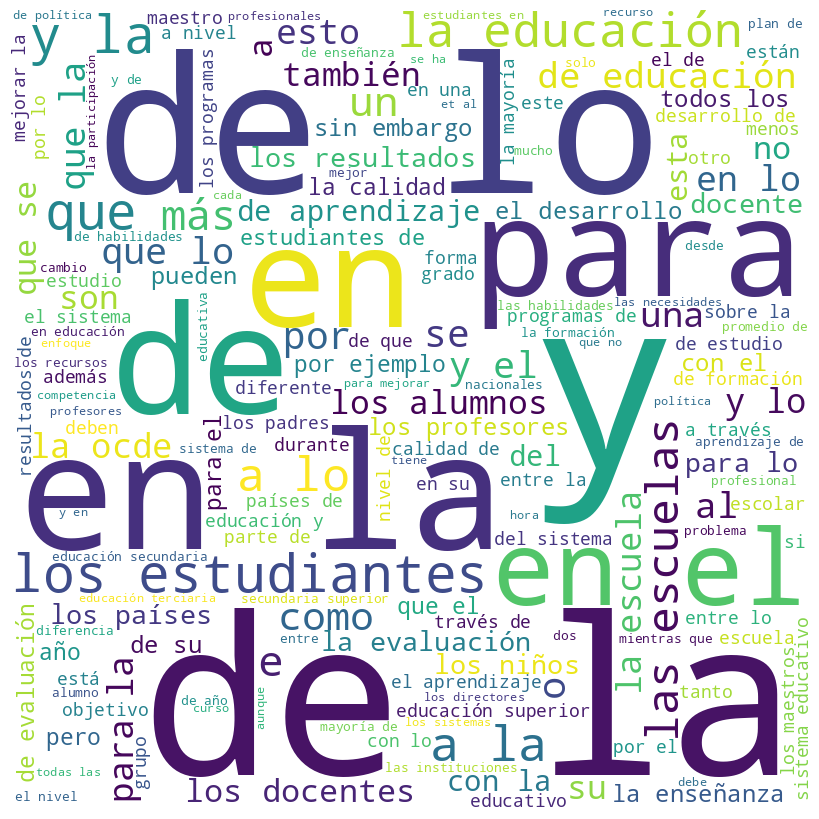

In [15]:
for i in [1,3,4]:
  print(f'---------- Nube de palabras para label = {i} ----------')
  show_wordcloud(df.loc[df['labels']==(i), 'textos'])

## STOPWORDS
Podemos mejorar los resultados de estas nubes de palabras mediante la eliminación de **StopWords**. Estos son palabras que no tienen mucha utilidad en este tipo de análisis como "de" o "la". Palabras que vemos son las más comunes en las nubes recién ploteadas.

In [16]:
STOPWORDS = set(stopwords.words("spanish"))

---------- Nube de palabras para label = 1 ----------


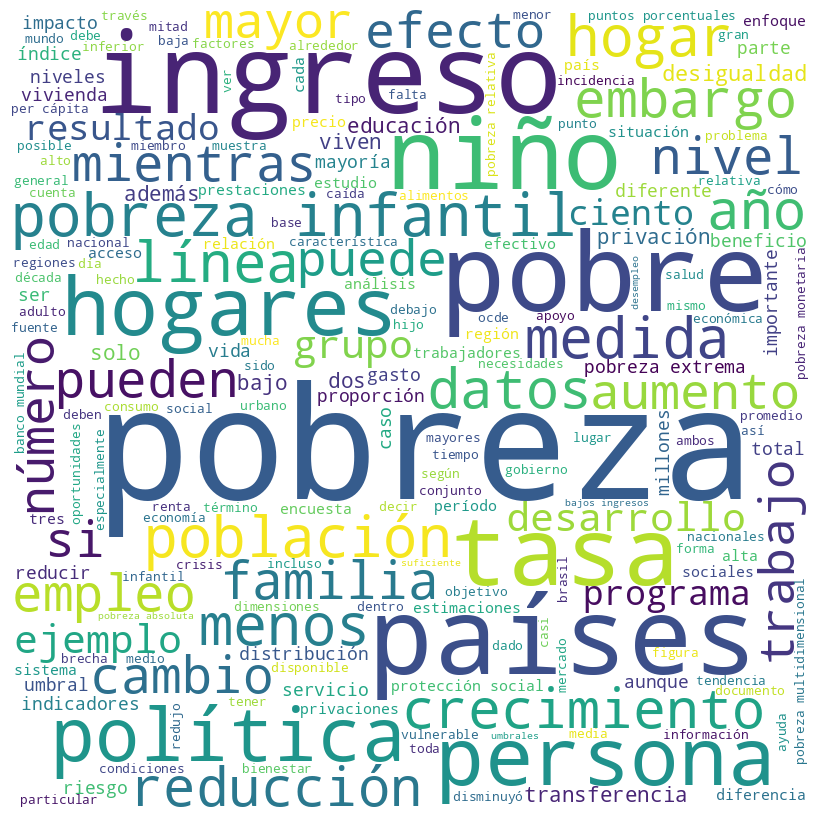

---------- Nube de palabras para label = 3 ----------


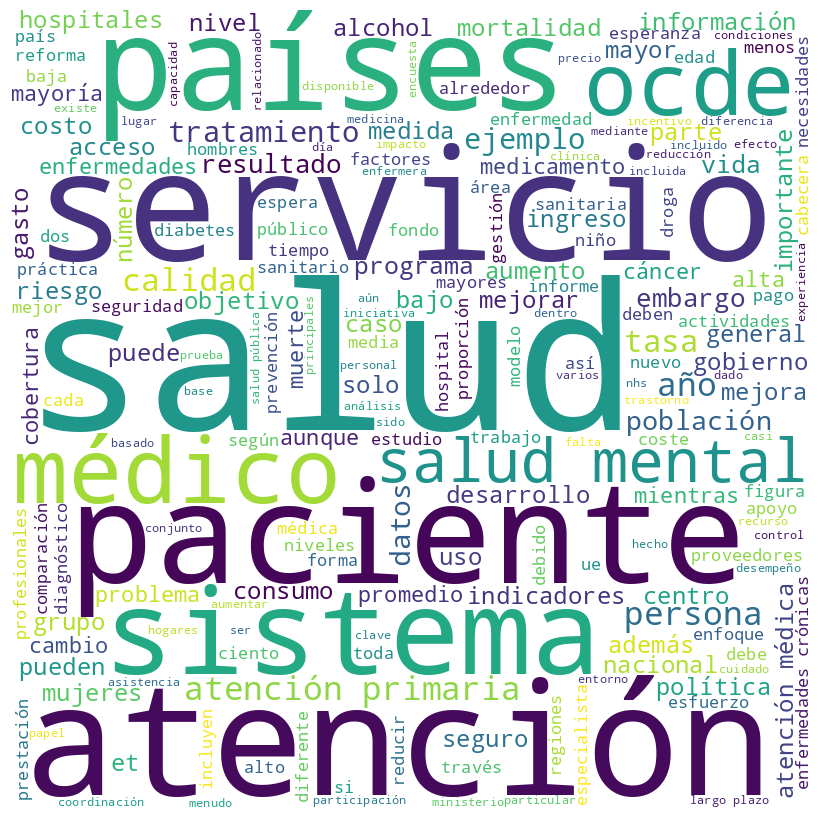

---------- Nube de palabras para label = 4 ----------


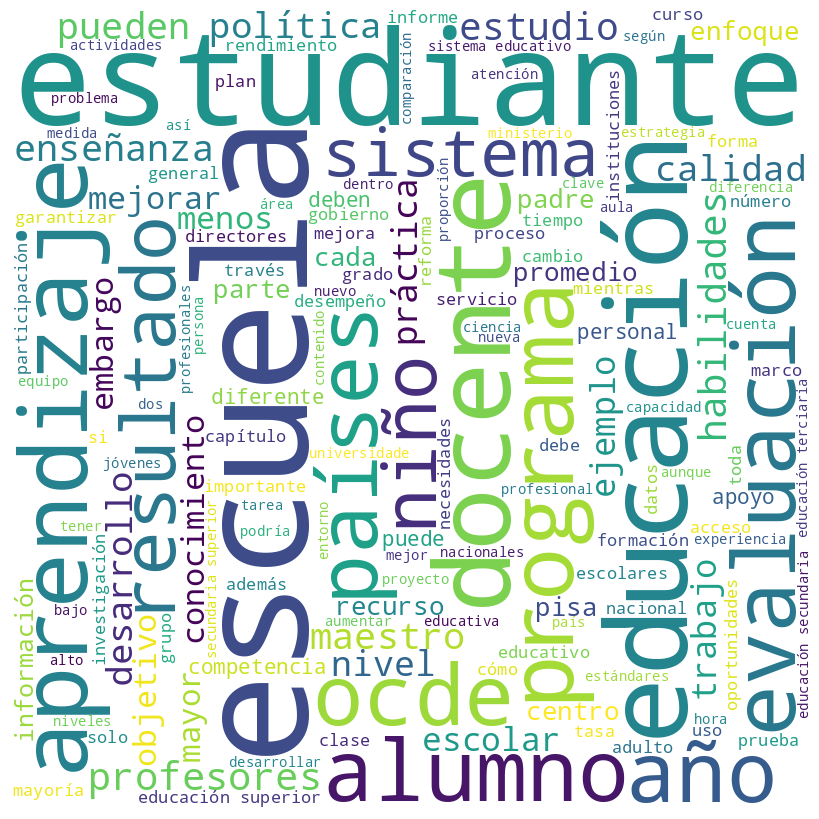

In [17]:
for i in [1,3,4]:
  print(f'---------- Nube de palabras para label = {i} ----------')
  show_wordcloud(df.loc[df['labels']==(i), 'textos'], stopwords=STOPWORDS)

Notamos que las nubes de palabras mejoran considerablemente al eliminar las StopWords. Nuestros resultados tienen sentido. Por ejemplo, para el label 4 (ODS 4, Educación y Calidad), notamos que algunos ejemplos de palabras más comunes son
- Escuela
- Estudiante
- Aprendizaje

Sin embargo, aún podemos mejorar más el procesamiento de los textos. Una técnica común en el procesamiento de lenguaje natural es el **Stemming**. Esta técnica consiste en reducir las palabras a su raíz, eliminando sufijos y prefijos. Por ejemplo, las palabras "correr", "corriendo" y "corrí" se reducirían a la raíz "corr". Esto ayuda a agrupar palabras similares y reducir la dimensionalidad del conjunto de datos.

En todo caso, haremos un primer intento de modelo sin Stemming. Evaluaremos su impacto evaluando primero sin stemming, y luego con stemming.

# 3. Inicio del modelamiento

In [18]:
X = df['textos']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train.to_frame(), y_train)

Dos cosas clave en el paso anterior:
1. Se estratificó en y a la hora de hacer la partición entre train y test. Es decir, la división se realizó manteniendo las proporciones en las que aparecía cada clase.
1. Realizamos un oversample en los datos de entrenamiento. Como discutimos antes, para lidiar con el hecho de que hay categorías bastante más comunes que otras en nuestros labels.

In [19]:
# print xTest dtype
print(X_test.dtypes)
X_test = X_test.to_frame()
print(X_test.dtypes)

object
textos    object
dtype: object


In [20]:
X_test

,textos
102,La relación entre el estatus étnico y el consu...
1220,"En los países de la OCDE, por cada reducción d..."
233,Una segunda etapa de seguimiento ocurre a los ...
2056,La persona respetable más pobre de cualquier s...
698,En ellos se basan las publicaciones anuales co...
...,...
2014,El Capítulo 4 analiza el impacto de las univer...
1429,"Sin embargo, en los últimos 40 años aproximada..."
148,"Sin embargo, MoES tiene un papel esencial que ..."
1391,Uno de los objetivos del Ministerio es preveni...


## 3.1 Modelo de Generación de vectores Binario (David Almanza)
Decidimos comenzar con en modelo demasiado simple. Realizaremos un modelo de Bolsa de Palabras con codificación de vectores binaria. El valor de cada columna es cada palabra en nuestro diccionario. Nuestras filas son cada uno de los textos. De esta manera, un campo $c_{i,j} = 1$, donde $i$ es la columna $i$ y $j$ es la fila $j$, si el texto $i$ contiene la palabra $j$.

Asímismo, para minimizar aún más la complejidad del modelo, no eliminaremos de él las STOPWORDS mencionadas anteriormente. Esto como ejercicio pedagógico, pues queremos posteriormente lograr el mejor modelo a nuestro alcance. Este modelo simple nos servirá entonces para medir la mejora que se puede llegar a lograr al usar diferentes técnicas de ML.

In [21]:
# Simple Binary Bag of Words Model (without stopwords removal for pedagogical purposes)

# Create binary vectorizer (no stopwords removal, simple binary encoding)
binary_vectorizer = CountVectorizer(binary=True, max_features=500)

# Fit and transform training data, transform test data
X_train_binary = binary_vectorizer.fit_transform(X_train['textos'])
X_test_binary = binary_vectorizer.transform(X_test['textos'])

# Simple Gaussian Naive Bayes classifier (no hyperparameter tuning)
simple_gnb = GaussianNB()

# Convert sparse matrices to dense for GaussianNB
X_train_binary_dense = X_train_binary.toarray()
X_test_binary_dense = X_test_binary.toarray()

# Fit the simple model
print("Entrenando modelo binario simple...")
simple_gnb.fit(X_train_binary_dense, y_train)

# Make predictions
y_pred_binary = simple_gnb.predict(X_test_binary_dense)

print("Modelo binario simple completado")
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred_binary))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_binary))

Entrenando modelo binario simple...
Modelo binario simple completado

Matriz de confusión:
[[ 92   5   4]
 [ 22 154   3]
 [  8   7 190]]

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.75      0.91      0.83       101
           3       0.93      0.86      0.89       179
           4       0.96      0.93      0.95       205

    accuracy                           0.90       485
   macro avg       0.88      0.90      0.89       485
weighted avg       0.91      0.90      0.90       485



Reporte de metricas - Modelo Binario


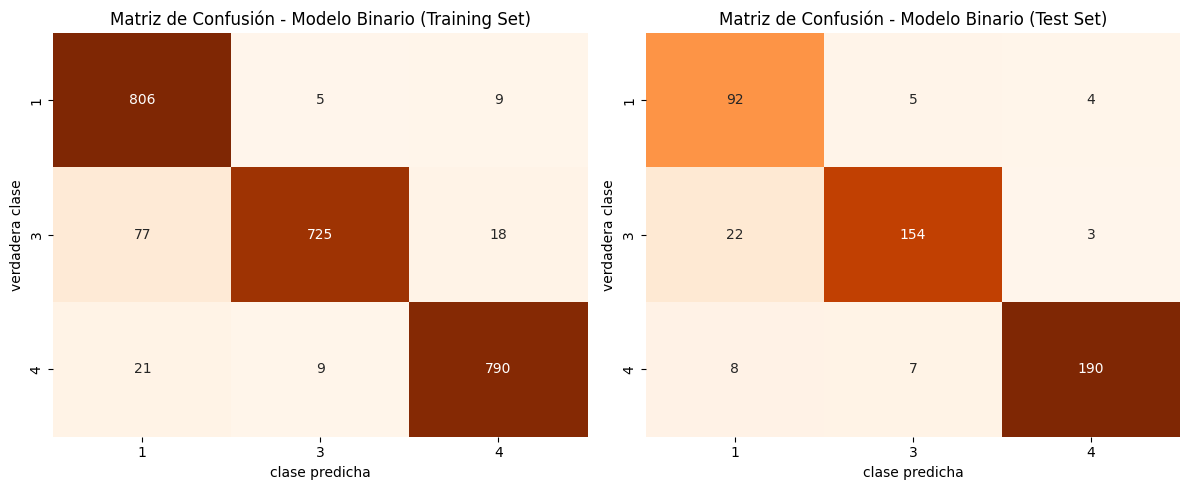


 Reporte de clasificacion - Modelo Binario (Entrenamiento):
              precision    recall  f1-score   support

           1       0.89      0.98      0.94       820
           3       0.98      0.88      0.93       820
           4       0.97      0.96      0.97       820

    accuracy                           0.94      2460
   macro avg       0.95      0.94      0.94      2460
weighted avg       0.95      0.94      0.94      2460


 Reporte de clasificacion - Modelo Binario (Test):
              precision    recall  f1-score   support

           1       0.75      0.91      0.83       101
           3       0.93      0.86      0.89       179
           4       0.96      0.93      0.95       205

    accuracy                           0.90       485
   macro avg       0.88      0.90      0.89       485
weighted avg       0.91      0.90      0.90       485



In [22]:
# Evaluate binary model results
y_train_pred_binary = simple_gnb.predict(X_train_binary_dense)
y_test_pred_binary = simple_gnb.predict(X_test_binary_dense)

print("Reporte de metricas - Modelo Binario")

cm_train_binary = confusion_matrix(y_train, y_train_pred_binary)
cm_test_binary = confusion_matrix(y_test, y_test_pred_binary)

classes = np.unique(y_train)
class_labels = [str(c) for c in classes]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train_binary, annot=True, fmt='d', cmap='Oranges', cbar=False, ax=axes[0],
            xticklabels=class_labels, yticklabels=class_labels)
axes[0].set_xlabel('clase predicha')
axes[0].set_ylabel('verdadera clase')
axes[0].set_title('Matriz de Confusión - Modelo Binario (Training Set)')

sns.heatmap(cm_test_binary, annot=True, fmt='d', cmap='Oranges', cbar=False, ax=axes[1],
            xticklabels=class_labels, yticklabels=class_labels)
axes[1].set_xlabel('clase predicha')
axes[1].set_ylabel('verdadera clase')
axes[1].set_title('Matriz de Confusión - Modelo Binario (Test Set)')

plt.tight_layout()
plt.show()

print("\n Reporte de clasificacion - Modelo Binario (Entrenamiento):")
print(classification_report(y_train, y_train_pred_binary))

print("\n Reporte de clasificacion - Modelo Binario (Test):")
print(classification_report(y_test, y_test_pred_binary))

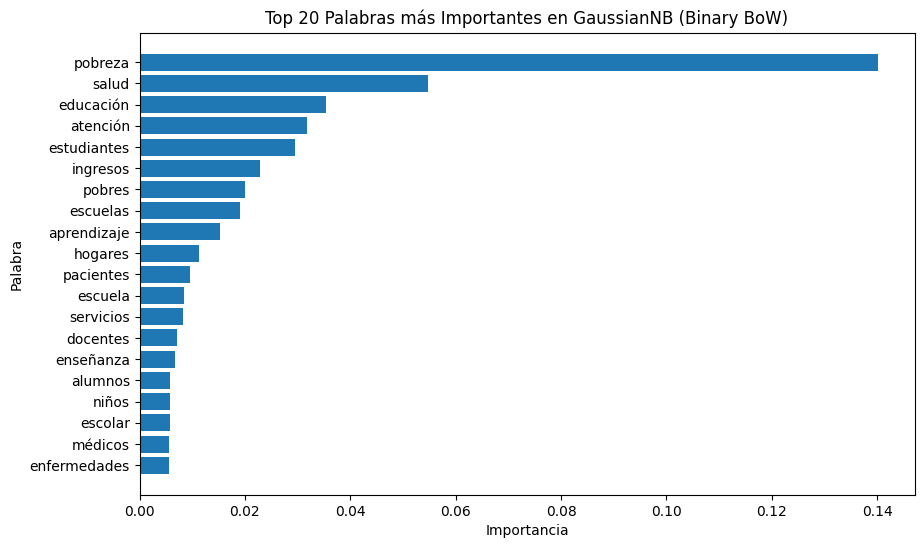

In [23]:

feature_names = binary_vectorizer.get_feature_names_out()
theta = simple_gnb.theta_

# Calcular importancia de cada palabra
if theta.shape[0] == 2:  # caso binario
    importance = np.abs(theta[0] - theta[1])
else:  # más de 2 clases
    importance = np.var(theta, axis=0)

# Ordenar
indices = np.argsort(importance)[::-1]
top_n = 20
top_features = [feature_names[i] for i in indices[:top_n]]
top_importances = importance[indices[:top_n]]

# Crear dataframe para la gráfica
df_importance = pd.DataFrame({
    "Palabra": top_features,
    "Importancia": top_importances
})

# Graficar
plt.figure(figsize=(10,6))
plt.barh(df_importance["Palabra"], df_importance["Importancia"])
plt.xlabel("Importancia")
plt.ylabel("Palabra")
plt.title("Top 20 Palabras más Importantes en GaussianNB (Binary BoW)")
plt.gca().invert_yaxis()
plt.show()



## 3.2 Modelo Tf-IDF (David Almanza)
En este modelo, queremos realizar un enfoque más sofisticado que en el anterior. Aplicaremos múltiples técnicas aprendidas a lo largo del semestre, con el objetivo de evaluar una mejora en los resultados. A diferencia del modelo anterior, en este realizamos un preprocesamiento con TF-IDF, en lugar de codificación binaria. Esto porque TF-IDF no captura únicamente la presencia de palabras, sino además pondera su importancia relativa al corpus de datos. Además, en este caso realizamos una eliminación de las STOPWORDS en el los datos, pues no tienen valor a la hora de realizar predicciones.

Posterior a esto, y teniendo en cuenta que el tamaño del espacio de entrada de nuestro modelo es igual al número de palabras diferentes en nuestros datos (Eliminando STOPWORDS), realizamos una reducción de la dimensionalidad con Singular Value Decomposition. Decidimos reducir la dimensionalidad porque tenemos un espacio de características muy grande y un dataset muy pequeño. Con esto esperaríamos atacar sobreajuste.

Usamos una vez más un clasificador Gaussian Naive Bayes, pero en esta ocasión realizamos una búsqueda de los mejores hiperparámetros mediante optimización Bayesiana. Evaluamos los sigiuentes hiperparámetros:
- max_features: Número máximo de features
- n_components: Dimensiones SVD
- var_smoothing: Suavizado para NB


In [24]:
spanish_stopwords = stopwords.words("spanish")

preprocessor = make_column_transformer(
    (TfidfVectorizer(stop_words=spanish_stopwords), 'textos')
)

pipeline_svd = Pipeline(
    [
        ("preprocessor", preprocessor),            
        ("svd", TruncatedSVD(random_state=77)),     
        ("gnb", GaussianNB()),                      
    ]
)

param_space_svd = {
    "gnb__var_smoothing": Real(1e-9, 1e-3, prior="log-uniform"),
    "preprocessor__tfidfvectorizer__max_features": Integer(50, 1000),
    "svd__n_components": Integer(2, 7, prior='uniform'),             
}


opt_svd = BayesSearchCV(
    pipeline_svd,
    search_spaces=param_space_svd,
    n_iter=30,
    cv=6,
    random_state=77,
    verbose=10,
    n_jobs=-1,
)

print("Iniciando búsqueda bayesiana")

opt_svd.fit(X_train, y_train)

print("Búsqueda completada")
print("Mejores hiperparámetros:")
print(opt_svd.best_params_)

print("Evaluando el modelo en el conjunto de prueba")
y_pred_svd = opt_svd.predict(X_test)

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_svd))

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_svd))


Iniciando búsqueda bayesiana
Fitting 6 folds for each of 1 candidates, totalling 6 fits
[CV 3/6; 1/1] START gnb__var_smoothing=1.097287379314942e-06, preprocessor__tfidfvectorizer__max_features=651, svd__n_components=4
[CV 6/6; 1/1] START gnb__var_smoothing=1.097287379314942e-06, preprocessor__tfidfvectorizer__max_features=651, svd__n_components=4
[CV 2/6; 1/1] START gnb__var_smoothing=1.097287379314942e-06, preprocessor__tfidfvectorizer__max_features=651, svd__n_components=4[CV 4/6; 1/1] START gnb__var_smoothing=1.097287379314942e-06, preprocessor__tfidfvectorizer__max_features=651, svd__n_components=4

[CV 1/6; 1/1] START gnb__var_smoothing=1.097287379314942e-06, preprocessor__tfidfvectorizer__max_features=651, svd__n_components=4
[CV 5/6; 1/1] START gnb__var_smoothing=1.097287379314942e-06, preprocessor__tfidfvectorizer__max_features=651, svd__n_components=4
[CV 6/6; 1/1] END gnb__var_smoothing=1.097287379314942e-06, preprocessor__tfidfvectorizer__max_features=651, svd__n_components

Reporte de metricas


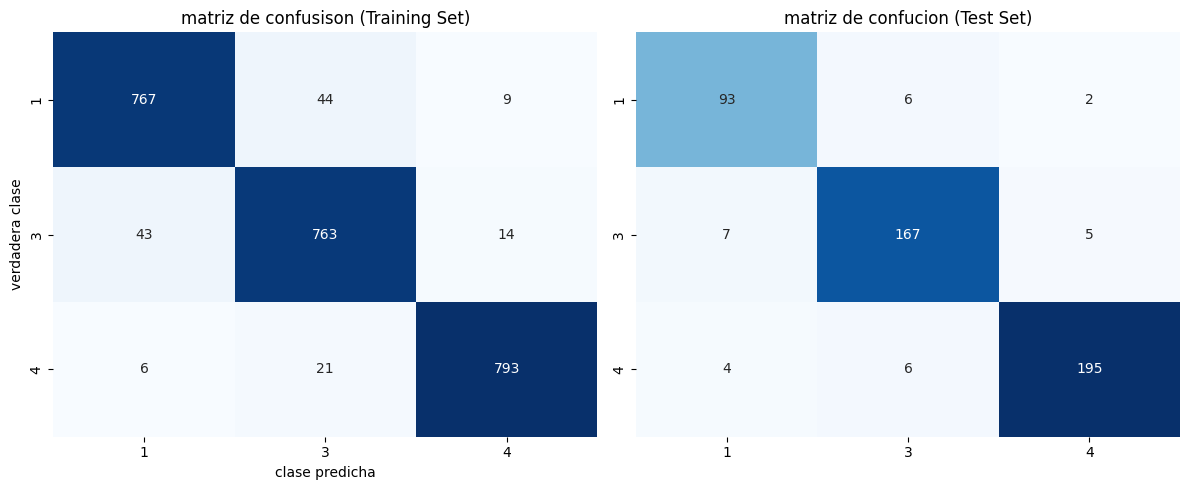


 Reporte de clasificacion (Entrenamiento):
              precision    recall  f1-score   support

           1       0.94      0.94      0.94       820
           3       0.92      0.93      0.93       820
           4       0.97      0.97      0.97       820

    accuracy                           0.94      2460
   macro avg       0.94      0.94      0.94      2460
weighted avg       0.94      0.94      0.94      2460


 Reporte de clasificacion (Test):
              precision    recall  f1-score   support

           1       0.89      0.92      0.91       101
           3       0.93      0.93      0.93       179
           4       0.97      0.95      0.96       205

    accuracy                           0.94       485
   macro avg       0.93      0.93      0.93       485
weighted avg       0.94      0.94      0.94       485



In [25]:
y_train_pred = opt_svd.predict(X_train)
y_test_pred = opt_svd.predict(X_test)


print("Reporte de metricas")

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

classes = np.unique(y_train)
class_labels = [str(c) for c in classes]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
            xticklabels=class_labels, yticklabels=class_labels)
axes[0].set_xlabel('clase predicha')
axes[0].set_ylabel('verdadera clase')
axes[0].set_title('matriz de confusison (Training Set)')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1],
            xticklabels=class_labels, yticklabels=class_labels)
axes[0].set_xlabel('clase predicha')
axes[0].set_ylabel('verdadera clase')
axes[1].set_title('matriz de confucion (Test Set)')

plt.tight_layout()
plt.show()

print("\n Reporte de clasificacion (Entrenamiento):")
print(classification_report(y_train, y_train_pred))

print("\n Reporte de clasificacion (Test):")
print(classification_report(y_test, y_test_pred))

/tmp/ipykernel_7304/903942003.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_words, palette="Blues_r")


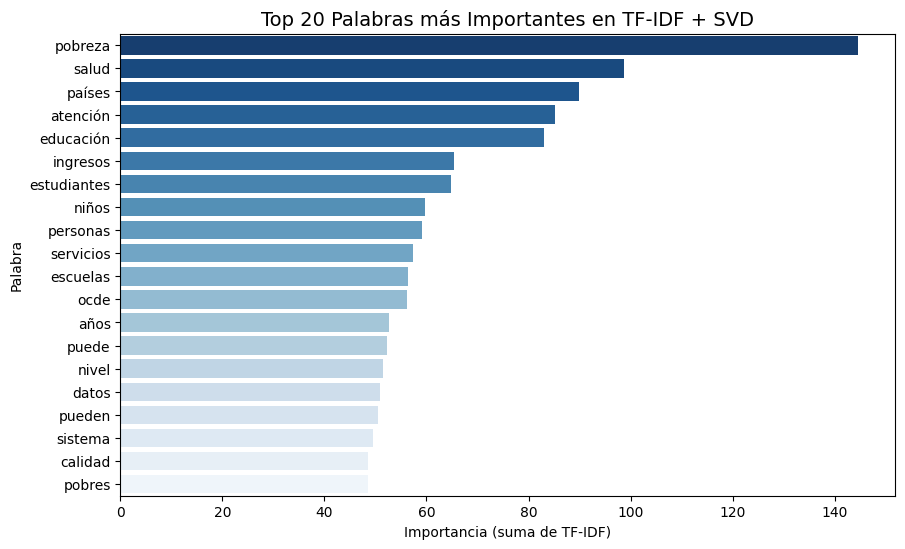

In [26]:
# Extraer las palabras del TF-IDF
feature_names = opt_svd.best_estimator_.named_steps["preprocessor"].named_transformers_["tfidfvectorizer"].get_feature_names_out()

# Calcular la importancia de cada palabra según TF-IDF (suma total de pesos en X_train)
tfidf_matrix = opt_svd.best_estimator_.named_steps["preprocessor"].transform(X_train)
word_importance = np.asarray(tfidf_matrix.sum(axis=0)).flatten()

# Seleccionar las top 20
top_n = 20
top_indices = word_importance.argsort()[::-1][:top_n]
top_words = [feature_names[i] for i in top_indices]
top_scores = word_importance[top_indices]

# Crear el gráfico
plt.figure(figsize=(10,6))
sns.barplot(x=top_scores, y=top_words, palette="Blues_r")
plt.title(f"Top {top_n} Palabras más Importantes en TF-IDF + SVD", fontsize=14)
plt.xlabel("Importancia (suma de TF-IDF)")
plt.ylabel("Palabra")
plt.show()



## 3.3 Random Forest (Maria Alejandra Londoño)

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train.to_frame(), y_train)

In [30]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train['textos'])  
X_test_vec = vectorizer.transform(X_test)  

In [31]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_vec, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [32]:
y_pred = rf.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))


Accuracy: 0.954639175257732

Reporte de Clasificación:
               precision    recall  f1-score   support

           1       0.98      0.90      0.94       101
           3       0.93      0.97      0.95       179
           4       0.97      0.97      0.97       205

    accuracy                           0.95       485
   macro avg       0.96      0.95      0.95       485
weighted avg       0.96      0.95      0.95       485



In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

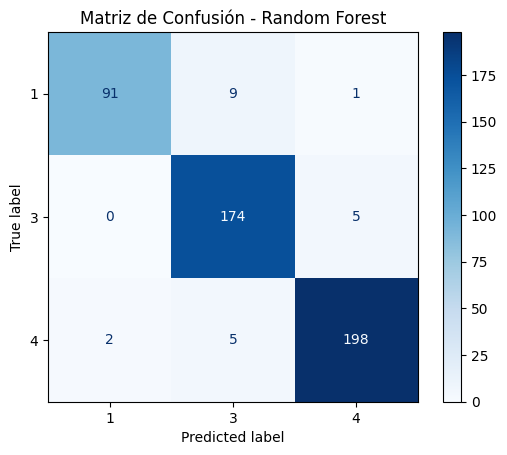

In [34]:
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)

# Mostrar la matriz en forma gráfica
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' = enteros
plt.title("Matriz de Confusión - Random Forest")
plt.show()

El modelo construido es un clasificador de texto basado en Random Forest. Lo que hace es tomar frases o documentos escritos y predecir a qué categoría pertenecen. Para lograrlo, primero convertimos los textos en vectores numéricos usando TF-IDF, una técnica que mide la importancia de cada palabra en relación con el conjunto de documentos. Además, como los datos podían estar desbalanceados, aplicamos RandomOverSampler para equilibrar las clases en el entrenamiento y evitar que el modelo favorezca siempre a la clase mayoritaria.

El entrenamiento consistió en dividir los datos en train y test, balancear los datos de entrenamiento y luego entrenar un RandomForestClassifier con 200 árboles de decisión. Una vez entrenado, evaluamos el modelo en ambos conjuntos (train y test) para comprobar tanto el aprendizaje como la capacidad de generalización. Finalmente, usamos métricas como accuracy, reporte de clasificación y matrices de confusión para ver visualmente qué tan bien predijo cada clase y si existía sobreajuste entre entrenamiento y prueba.

In [35]:
# Importancias de las features
importances = rf.feature_importances_

# Asociar cada importancia con su palabra
feature_names = vectorizer.get_feature_names_out()
feat_imp = pd.DataFrame({
    "palabra": feature_names,
    "importancia": importances
})

# Ordenar de mayor a menor
feat_imp = feat_imp.sort_values(by="importancia", ascending=False)

print(feat_imp.head(20))  # Top 20 palabras más importantes


           palabra  importancia
3668       pobreza     0.086225
4332         salud     0.036538
1744     educación     0.027611
2054   estudiantes     0.026595
574       atención     0.021763
3667        pobres     0.018387
1941      escuelas     0.017632
482    aprendizaje     0.016719
2700      ingresos     0.013135
3475     pacientes     0.011408
1940       escuela     0.011408
1859  enfermedades     0.010675
394        alumnos     0.010443
1880     enseñanza     0.009976
3237       médicos     0.009619
1933       escolar     0.008962
1680      docentes     0.008958
2492       hogares     0.007976
3108        mental     0.007367
3832     privación     0.006831


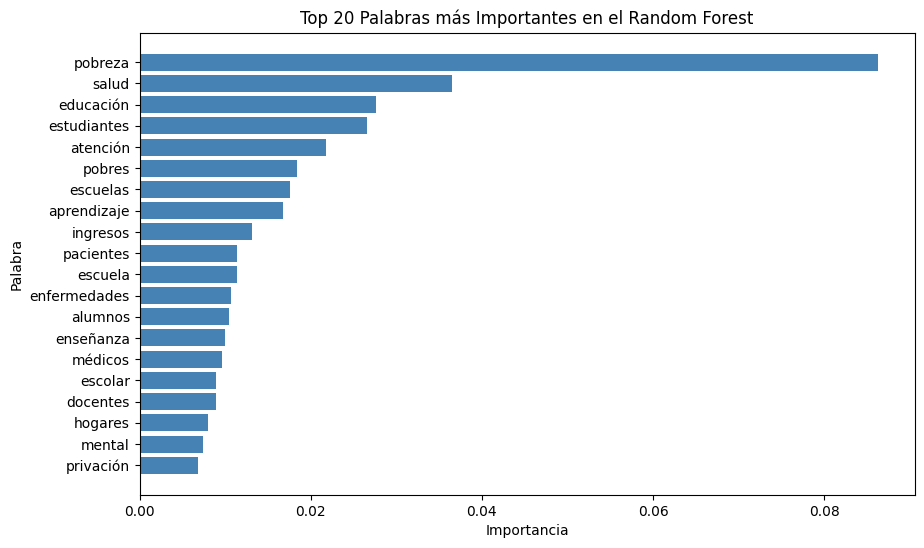

In [36]:
# Obtener importancias y nombres de features
importances = rf.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Crear DataFrame con palabras e importancia
feat_imp = pd.DataFrame({
    "palabra": feature_names,
    "importancia": importances
})

# Ordenar y quedarnos con las top 20
top_words = feat_imp.sort_values(by="importancia", ascending=False).head(20)

# Gráfico de barras
plt.figure(figsize=(10,6))
plt.barh(top_words["palabra"], top_words["importancia"], color="steelblue")
plt.gca().invert_yaxis()  # Para que la más importante quede arriba
plt.xlabel("Importancia")
plt.ylabel("Palabra")
plt.title("Top 20 Palabras más Importantes en el Random Forest")
plt.show()


# Discusión de Resultados

Resulta interesante el análisis de estos resultados, porque todos los modelos desarrollados, muestran resultados bastante similares y buenos. Comenzaremos hablando de los requerimientos de negocio para definir la mejor métrica para evaluar nuestros modelos en esta sección. Como ya sabemos, el objetivo del UNFPA es el de vincular automáticamente las opiniones de la ciudadanía con ODSs. Teniendo esto en cuenta, y suponiendo que todos los ODS son igualmente importantes, a priori no podemos darle mayor importancia a ninguno de los labels/categorías a identificar. En modelos en los que se prioriza la capacidad del modelo de encontrar todos los casos positivos reales, se usa recall. Esto corresponde a detección de fraude, anomalías, etc. Casos en los que un falso negativo es mucho más grave que un falso positivo. Este caso no es exactamente así. Sin embargo, confiar únicamente en la precisión, que mide la fiabilidad de las predicciones positivas de un modelo, podría no ser bueno tampoco.

Teniendo esto en mente, decidimos usar el f1-score. Este es un valor que combina la presición y el recall medianta su media armónica. Asimismo, y teniendo en cuenta que como mencionamos antes, ninguna de las clases es más valiosa que las otras. Promediaremos el f1-score de las tres clases. Esta será la métrica (sobre conjunto test) que usaremos para comparar nuestros modelos. Consideramos que se alinea con los objetivos del stake-holder.

- Comencemos por el modelo de vectores binarios, el cual era, de lejos, el más simple. Con un $\text{f1-score}_{avg} = 0.89$, este modelo nos sorprendió. Definitivamente esperabamos resultados peores. Sobretodo teniendo en cuenta que se muestra muy competente con respecto a los otros modelos.
- El modelo "TF-IDF" (lo llamaremos así aunque el tercero también usa esta técnica) muestra resultados mejores que el anterior. Con un $\text{f1-score}_{avg} = 0.94$, este modelo tiene un desempeño bastante bueno. Era de esperarse, pues aplica múltiples técnicas diferentes de ML para mejorar su rendimiento. Asimismo, aplica un procesado a los datos que no se aplica en los otros modelos: Eliminación de stopWords. Como este es el modelo que tiene el espacio de features más pequeño, podríamos decir que es el que mejor uso de recursos computacionales (memoria) hace.
- Finalmente, el modelo de Random Forest. Este tiene un $\text{f1-score}_{avg} = 0.95$, venciendo el modelo anterior por poco. Sin embargo, con 200 árboles, este es el modelo más complejo de todos.


Habiendo dicho lo anterior, le planteamos el uso de dos diferentes modelos a la UNFPA:
- Si de resultados se trata, les recomendamos el modelo del Random Forest. Este es el modelo que mayor número de predicciones exitosas les traerá.
- Sin embargo, teniendo en cuenta que el anterior es el modelo más complejo, y que los textos son conjuntos de datos grandes y difíciles de tratar en términos de recursos computacionales (al menos bajo el método de BOW usado), por sus enormes espacios de features asociados. Pensamos que el modelo TF-IDF podría ser una buena opción. Elimina la problemática anterior, y sin embargo da resultados casi iguales.

Le dejamos la decisión a la organización!

## Discusión del análisis de palabras identificadas
---


## Nuevas Predicciones

In [39]:
new_df = pd.read_excel('Datos-de-prueba_proyecto.xlsx')
print(new_df.head())
print(f"\nTamaño del dataset: {new_df.shape}")

                                      Textos_espanol
0  El rector, que es el representante local del M...
1  Tenga en cuenta que todos los programas antipo...
2  Debido a que son en gran medida invisibles, es...
3  Los recursos aún son limitados en este sector....
4  Durante el período 1985-2008, la educación pri...

Tamaño del dataset: (152, 1)


In [40]:
X_new_vec = vectorizer.transform(new_df['Textos_espanol'])
y_pred_new = rf.predict(X_new_vec)

In [ ]:
new_df['prediccion_ods'] = y_pred_new

print("Predicciones completadas!")
print(f"\nDistribución de predicciones:")
print(new_df['prediccion_ods'].value_counts().sort_index())

print(f"\nPrimeras 10 predicciones:")
print(new_df[['Textos_espanol', 'prediccion_ods']].head(10))

output_filename = 'Datos_proyecto_con_predicciones.xlsx'
new_df.to_excel(output_filename, index=False)

print(f"\nArchivo guardado como: {output_filename}")
print("¡Proceso completado exitosamente!")

Predicciones completadas!

Distribución de predicciones:
prediccion_ods
1    50
3    52
4    50
Name: count, dtype: int64

Primeras 10 predicciones:
                                      Textos_espanol  prediccion_ods
0  El rector, que es el representante local del M...               4
1  Tenga en cuenta que todos los programas antipo...               3
2  Debido a que son en gran medida invisibles, es...               1
3  Los recursos aún son limitados en este sector....               3
4  Durante el período 1985-2008, la educación pri...               4
5  En la región de Asia y el Pacífico, casi el 87...               3
6  Esta combinación representa una oportunidad pa...               4
7  Además, muchos llevan a cabo prácticas de segu...               4
8  El alcance de esta visión holística se basa en...               4
9  Véase C. Correa, "Protecting Test Data for Pha...               3

Archivo guardado como: Datos_proyecto_con_predicciones.xlsx
¡Proceso completado exitosament